In [20]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import QFT
from qiskit.primitives import Sampler
from qiskit.visualization import plot_histogram
from numpy import pi
import matplotlib.pyplot as plt


m = 16  # Number of control qubits
theta = 0.3647853

control_register = QuantumRegister(m, name="Control")
target_register = QuantumRegister(1, name="|ψ>")
output_register = ClassicalRegister(m, name="Result")
qc = QuantumCircuit(control_register, target_register, output_register)

# Prepare the eigenvector |ψ>
qc.x(target_register)
qc.barrier()

# Perform phase estimation
for index, qubit in enumerate(control_register):
    qc.h(qubit)
    for _ in range(2**index):
        qc.cp(2 * pi * theta, qubit, target_register)
qc.barrier()

# Do inverse quantum Fourier transform
qc.compose(
    QFT(m, inverse=True),
    inplace=True
)

# Measure everything
qc.measure(range(m), range(m))
#display(qc.draw(output='mpl'))

In [21]:
# Define a local backend
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit import transpile

service = QiskitRuntimeService()

backend = service.least_busy(operational=True, simulator=False)

pm = generate_preset_pass_manager(optimization_level=1, backend=backend)
isa_circuit = pm.run(qc)

sampler = Sampler(mode=backend)

job = sampler.run([isa_circuit])

result = job.result()


RuntimeJobFailureError: 'Unable to retrieve job result. The instruction cost per qubit exceeds the system limit . -- Split circuits/pubs into multiple jobs. -- https://ibm.biz/error_codes#1520'

In [15]:
pub_result = result[0].data.Result.get_counts()
print(pub_result)

max_count = int(pub_result.most_frequent(), 2)
print(f"Most probable output: {max_count}")
print(f"Estimated theta: {max_count/2**m}")
print(f"Actual theta: {theta}")
print("Percentage error: {0:.3f}".format((theta - max_count/2**m)*100/theta))


{'11011': 62, '11111': 94, '01101': 107, '01000': 217, '01010': 106, '11000': 241, '00100': 240, '00101': 130, '00001': 139, '00111': 55, '00110': 104, '10110': 128, '10001': 79, '11001': 99, '11101': 150, '11100': 252, '11110': 142, '00011': 53, '11010': 133, '00000': 253, '01001': 103, '10101': 118, '10111': 78, '01100': 214, '10000': 162, '10100': 171, '10010': 104, '01011': 47, '10011': 54, '00010': 114, '01110': 94, '01111': 53}


AttributeError: 'dict' object has no attribute 'most_frequent'

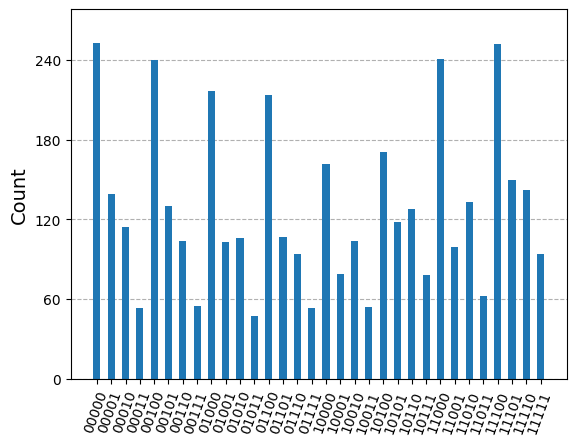

In [17]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService(
    channel='ibm_quantum',
    instance='ibm-q/open/main',
    token='63daf9a7e4a8d389f25342b84a4592fe47bba144a477be3383a3f7759c1c32d6e80ba0e04899b0949b0ac9821c45ba35f29c704e9a090f7ba4a938b59ede3785'
)
job = service.job('ctkv8n24gjh0008p66ag')
job_result = job.result()

# To get counts for a particular pub result, use 
#
pub_result = job_result[0].data.Result.get_counts()

#
# where <idx> is the index of the pub and <classical register> is the name of the classical register. 
# You can use circuit.cregs to find the name of the classical registers.

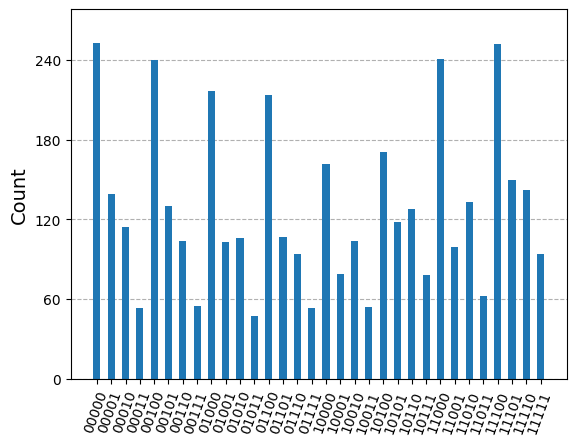

In [18]:
plot_histogram(pub_result, bar_labels=False)

AttributeError: 'NoneType' object has no attribute 'savefig'

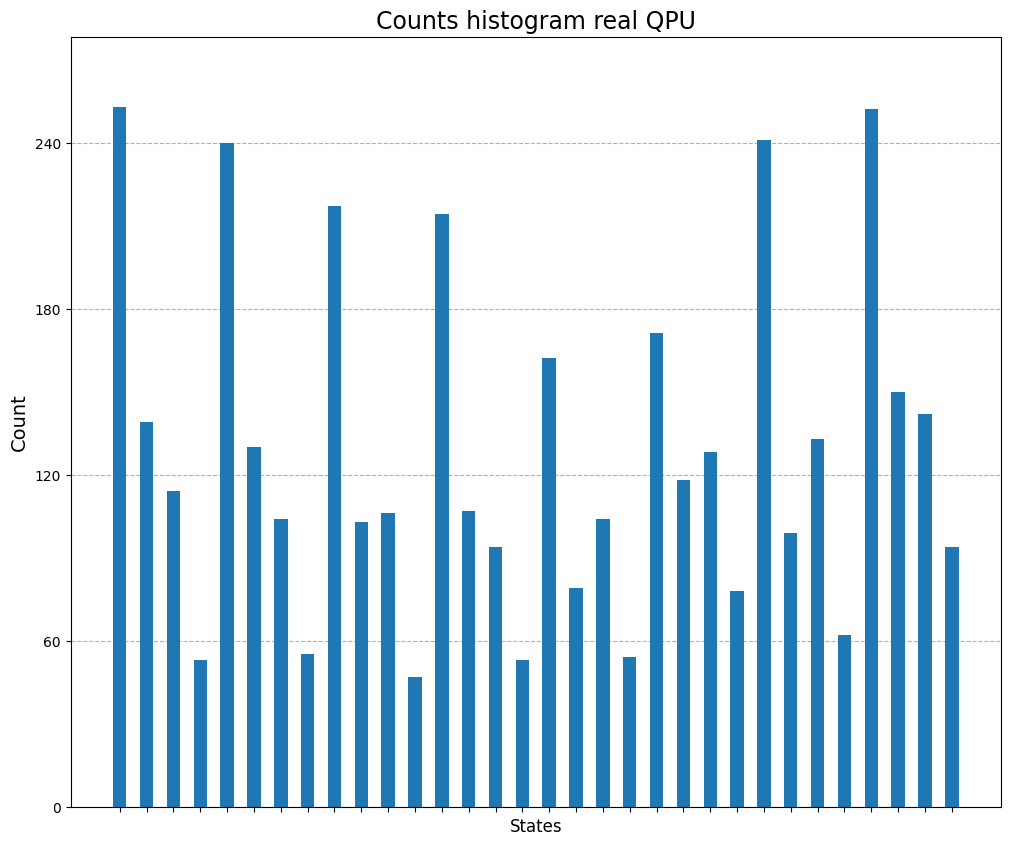

In [19]:

fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111)
ax.set_title("Counts histogram real QPU", fontsize=17)
ax.set_xlabel('States', fontsize=12)
ax.set_ylabel("Counts", fontsize=12)
plt.xticks(visible=False)
#ax.text(x=500,y=16, horizontalalignment='right', s=(r"Estimated $\theta$: {0:.7f}".format(max_count/2**m) + "\n" + r"Actual $\theta$: {}".format(theta) + "\n" + "Percentage error: {0:.3f}".format((abs(theta - max_count/2**m))*100/theta)),bbox=dict(facecolor='dodgerblue',alpha=0.7), fontsize=12)

plot_histogram(pub_result, bar_labels=False, ax=ax, filename='Real_phase_est_5qubits.pdf')